# Cass-Koopmans Competitive Equilibrium

In [1]:
from numba import njit, jitclass, float64
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
planning_data = [
    ('γ', float64),    # Coefficient of relative risk aversion
    ('β', float64),    # Discount factor
    ('δ', float64),    # Depreciation rate on capital
    ('α', float64),    # Return to capital per capita
    ('A', float64)     # Technology
]

In [3]:
@jitclass(planning_data)
class PlanningProblem():

    def __init__(self, γ=2, β=0.95, δ=0.02, α=0.33, A=1):

        self.γ, self.β = γ, β
        self.δ, self.α, self.A = δ, α, A

    def u(self, c):
        '''
        Utility function
        ASIDE: If you have a utility function that is hard to solve by hand
        you can use automatic or symbolic differentiation
        See https://github.com/HIPS/autograd
        '''
        γ = self.γ

        return c ** (1 - γ) / (1 - γ) if γ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        γ = self.γ

        return c ** (-γ)

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        γ = self.γ

        return c ** (-1 / γ)

    def f(self, k):
        'Production function'
        α, A = self.α, self.A

        return A * k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α, A = self.α, self.A

        return α * A * k ** (α - 1)

    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α, A = self.α, self.A

        return (k / (A * α)) ** (1 / (α - 1))

    def next_k_c(self, k, c):
        ''''
        Given the current capital Kt and an arbitrary feasible
        consumption choice Ct, computes Kt+1 by state transition law
        and optimal Ct+1 by Euler equation.
        '''
        β, δ = self.β, self.δ
        u_prime, u_prime_inv = self.u_prime, self.u_prime_inv
        f, f_prime = self.f, self.f_prime

        k_next = f(k) + (1 - δ) * k - c
        c_next = u_prime_inv(u_prime(c) / (β * (f_prime(k_next) + (1 - δ))))

        return k_next, c_next

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  """Entry point for launching an IPython kernel.


In [4]:
@njit
def shooting(pp, c0, k0, T=10):
    '''
    Given the initial condition of capital k0 and an initial guess
    of consumption c0, computes the whole paths of c and k
    using the state transition law and Euler equation for T periods.
    '''
    if c0 > pp.f(k0):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = pp.next_k_c(k_vec[t], c_vec[t])

    k_vec[T+1] = pp.f(k_vec[T]) + (1 - pp.δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

In [5]:
@njit
def bisection(pp, c0, k0, T=10, tol=1e-4, max_iter=500, k_ter=0, verbose=True):

    # initial boundaries for guess c0
    c0_upper = pp.f(k0)
    c0_lower = 0

    i = 0
    while True:
        c_vec, k_vec = shooting(pp, c0, k0, T)
        error = k_vec[-1] - k_ter

        # check if the terminal condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration ', i+1)
            return c_vec, k_vec

        i += 1
        if i == max_iter:
            if verbose:
                print('Convergence failed.')
            return c_vec, k_vec

        # if iteration continues, updates boundaries and guess of c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0

        c0 = (c0_lower + c0_upper) / 2

In [6]:
pp = PlanningProblem()

# Steady states
ρ = 1 / pp.β - 1
k_ss = pp.f_prime_inv(ρ+pp.δ)
c_ss = pp.f(k_ss) - pp.δ * k_ss

In [7]:
@njit
def q(pp, c_path):
    # Here we choose numeraire to be u'(c_0) -- this is q^(t_0)_t
    T = len(c_path) - 1
    q_path = np.ones(T+1)
    q_path[0] = 1
    for t in range(1, T+1):
        q_path[t] = pp.β ** t * pp.u_prime(c_path[t])
    return q_path

@njit
def w(pp, k_path):
    w_path = pp.f(k_path) - k_path * pp.f_prime(k_path)
    return w_path

@njit
def η(pp, k_path):
    η_path = pp.f_prime(k_path)
    return η_path

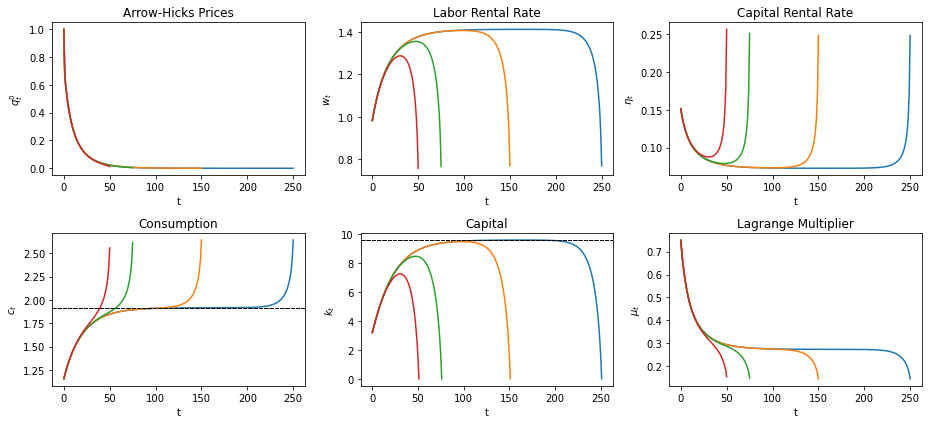

In [8]:
T_arr = [250, 150, 75, 50]

fix, axs = plt.subplots(2, 3, figsize=(13, 6))
titles = ['Arrow-Hicks Prices', 'Labor Rental Rate', 'Capital Rental Rate',
          'Consumption', 'Capital', 'Lagrange Multiplier']
ylabels = ['$q_t^0$', '$w_t$', '$\eta_t$', '$c_t$', '$k_t$', '$\mu_t$']

for T in T_arr:
    c_path, k_path = bisection(pp, 0.3, k_ss/3, T, verbose=False)
    μ_path = pp.u_prime(c_path)

    q_path = q(pp, c_path)
    w_path = w(pp, k_path)[:-1]
    η_path = η(pp, k_path)[:-1]
    paths = [q_path, w_path, η_path, c_path, k_path, μ_path]

    for i, ax in enumerate(axs.flatten()):
        ax.plot(paths[i])
        ax.set(title=titles[i], ylabel=ylabels[i], xlabel='t')
        if titles[i] is 'Capital':
            ax.axhline(k_ss, lw=1, ls='--', c='k')
        if titles[i] is 'Consumption':
            ax.axhline(c_ss, lw=1, ls='--', c='k')

plt.tight_layout()
plt.show()

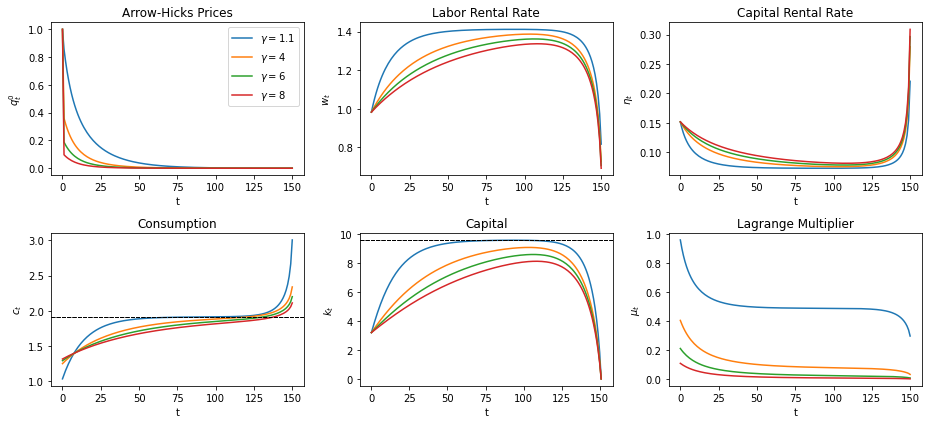

In [9]:
T = 150
γ_arr = [1.1, 4, 6, 8]

fix, axs = plt.subplots(2, 3, figsize=(13, 6))

for γ in γ_arr:
    pp_γ = PlanningProblem(γ=γ)
    c_path, k_path = bisection(pp_γ, 0.3, k_ss/3, T, verbose=False)
    μ_path = pp_γ.u_prime(c_path)

    q_path = q(pp_γ, c_path)
    w_path = w(pp_γ, k_path)[:-1]
    η_path = η(pp_γ, k_path)[:-1]
    paths = [q_path, w_path, η_path, c_path, k_path, μ_path]

    for i, ax in enumerate(axs.flatten()):
        ax.plot(paths[i], label=f'$\gamma = {γ}$')
        ax.set(title=titles[i], ylabel=ylabels[i], xlabel='t')
        if titles[i] is 'Capital':
            ax.axhline(k_ss, lw=1, ls='--', c='k')
        if titles[i] is 'Consumption':
            ax.axhline(c_ss, lw=1, ls='--', c='k')

axs[0, 0].legend()
plt.tight_layout()
plt.show()

In [10]:
@njit
def q_generic(pp, t0, c_path):
    # simplify notations
    β = pp.β
    u_prime = pp.u_prime

    T = len(c_path) - 1
    q_path = np.zeros(T+1-t0)
    q_path[0] = 1
    for t in range(t0+1, T+1):
        q_path[t-t0] = β ** (t-t0) * u_prime(c_path[t]) / u_prime(c_path[t0])
    return q_path

@njit
def r(pp, t0, q_path):
    '''Yield to maturity'''
    r_path = - np.log(q_path[1:]) / np.arange(1, len(q_path))
    return r_path

def plot_yield_curves(pp, t0, c0, k0, T_arr):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for T in T_arr:
        c_path, k_path = bisection(pp, c0, k0, T, verbose=False)
        q_path = q_generic(pp, t0, c_path)
        r_path = r(pp, t0, q_path)

        axs[0].plot(range(t0, T+1), q_path)
        axs[0].set(xlabel='t', ylabel='$q_t^0$', title='Hicks-Arrow Prices')

        axs[1].plot(range(t0+1, T+1), r_path)
        axs[1].set(xlabel='t', ylabel='$r_t^0$', title='Yields')

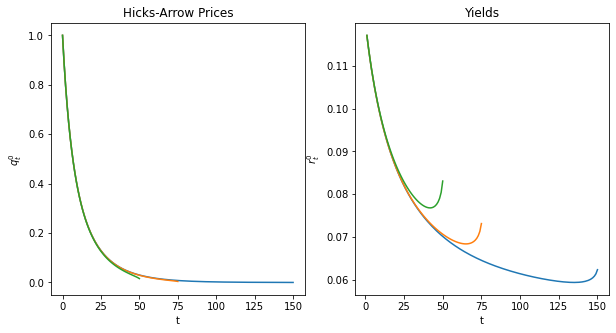

In [11]:
T_arr = [150, 75, 50]
plot_yield_curves(pp, 0, 0.3, k_ss/3, T_arr)

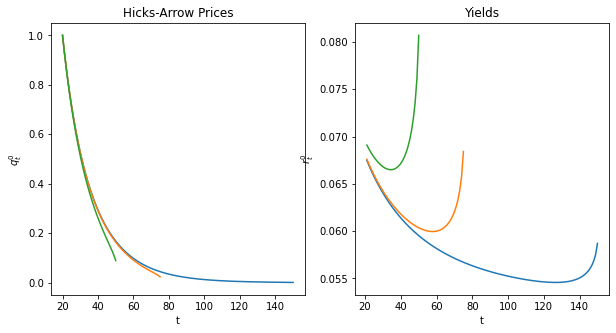

In [12]:
plot_yield_curves(pp, 20, 0.3, k_ss/3, T_arr)